In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.applications import DenseNet121,DenseNet169,  \
                                          DenseNet201,InceptionResNetV2,  \
                                          InceptionV3,MobileNet,MobileNetV2,  \
                                          NASNetLarge,NASNetMobile,ResNet101,  \
                                          ResNet101V2,ResNet152,ResNet152V2,  \
                                          ResNet50,ResNet50V2,VGG16,VGG19,Xception 

from pathlib import Path


import cv2

import math
import warnings

from datetime import datetime
import sys

selected_gpu = 0

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_visible_devices(gpus[selected_gpu], 'GPU')

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:

IMG_HEIGHT = 512
IMG_WIDTH = 512
EPOCHS = 6
fine_tune_epochs = 8
unfreeze_epochs = 8

CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)



lrs = [('6e-4',6e-4), ('1e-3',1e-3), ('6e-3',6e-3)]
batch_sizes = [('8',8),('16',16)]
BATCH_SIZE = batch_sizes[1][1]
optimizers = ['Adam', 'Nadam', 'SGD']
opt = 'Nadam'

l = lrs[1]
lr = l[1]

mode = 'mixed'
one_hot = 'one_hot'
from_logits = True
activation = "linear"

output_nodes = 2


losses = ['Binary', 'Categorical']

loss = losses[1]

data_aug = "augment"

In [6]:
metrics = ['accuracy']

In [7]:
IMAGE_DIR = "/opt/AIStorage/PLAYGROUND/images/512/filtered/all_images"

In [8]:
#val_data_dir = '/opt/AIStorage/PLAYGROUND/data/validation'
#val_data_dir = '/opt/AIStorage/PLAYGROUND/images/1024/validation'
val_data_dir = '/opt/AIStorage/PLAYGROUND/images/512/filtered/train_validation_test/validation'
val_data_dir = pathlib.Path(val_data_dir)

#data_dir = '/opt/AIStorage/PLAYGROUND/data/train'
#data_dir = '/opt/AIStorage/PLAYGROUND/images/1024/train'
data_dir = '/opt/AIStorage/PLAYGROUND/images/512/filtered/train_validation_test/train'
data_dir = pathlib.Path(data_dir)

test_data_dir = '/opt/AIStorage/PLAYGROUND/images/512/filtered/train_validation_test/test'
test_data_dir = pathlib.Path(test_data_dir)

In [9]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

7063

In [10]:
val_image_count = len(list(val_data_dir.glob('*/*.png')))
val_image_count

882

In [11]:
test_image_count = len(list(test_data_dir.glob('*/*.png')))
test_image_count

882

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

In [13]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = tf.constant([1.0, 0.0])
  else:
    label = tf.constant([0.0, 1.0])
  return label

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [15]:
def decode_img_aug(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
 
  #augment data for training
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  img = tf.image.random_brightness(img, 0.2)
    
  return img

In [16]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [17]:
def process_path_aug(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img_aug(img)
  return img, label

In [18]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path_aug, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

TEST_STEPS_PER_EPOCH = np.ceil(test_image_count/BATCH_SIZE)

In [20]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  [0. 1.]


In [21]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  [1. 0.]


In [22]:
#augmentation code not working yet
def augment(image,label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    return image,label

In [23]:
def prepare_for_training(ds, shuffle=True, cache=False, shuffle_buffer_size=10000, augment=False):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
        
  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [24]:
train_ds = prepare_for_training(labeled_ds, shuffle=True, cache=True)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds

test_ds = prepare_for_training(test_labeled_ds, shuffle=False)

image_batch, label_batch = next(iter(train_ds))

In [25]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      
      plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

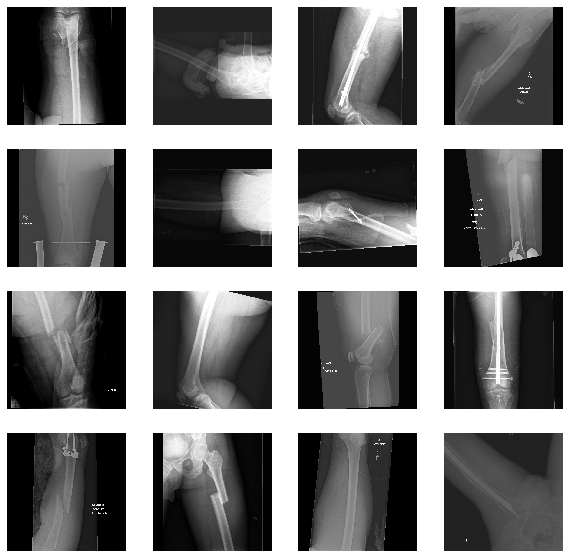

In [26]:
show_batch(image_batch, label_batch)

In [27]:
image_batch, label_batch = next(iter(train_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

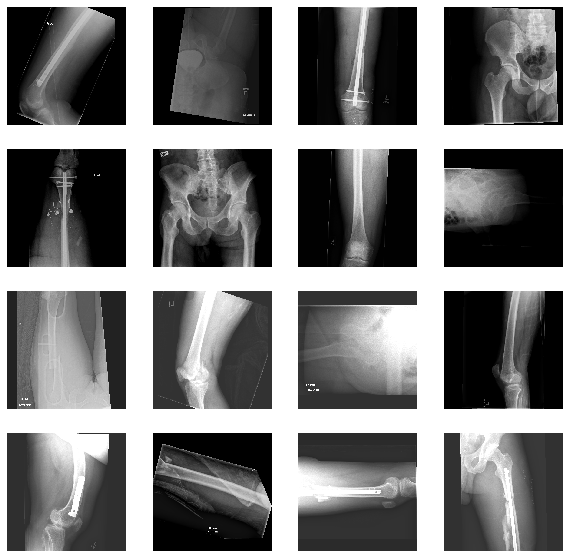

In [28]:
show_batch(image_batch, label_batch)

In [29]:
"""
Module for Image Save
"""


def save_grayscale(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 1) as an image.
    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(str(Path(output_dir) / output_name), image)


def save_rgb(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 3) as an image.
    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(
        str(Path(output_dir) / output_name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    )

In [30]:
def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid


def filter_display(array, num_rows=None, num_columns=None):
    """
    Display a list of filter outputs as a greyscale images grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    return grid_display(
        np.concatenate(np.rollaxis(array, 3, 1), axis=0), num_rows, num_columns
    )


def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")


def heatmap_display(
    heatmap, original_image, colormap=cv2.COLORMAP_VIRIDIS, image_weight=0.7
):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply the heatmap
        colormap (int): OpenCV Colormap to use for heatmap visualization
        image_weight (float): An optional `float` value in range [0,1] indicating the weight of
            the input image to be overlaying the calculated attribution maps. Defaults to `0.7`
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    image = image_to_uint_255(original_image)

    epsilon = 0.0
    if (heatmap.max() - heatmap.min()) == 0:
        epsilon = sys.float_info.epsilon
        
    
    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min() + epsilon)

    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )

    output = cv2.addWeighted(
        cv2.cvtColor(image, cv2.COLOR_RGB2BGR), image_weight, heatmap, 1, 0
    )

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [31]:
"""
Core Module for Grad CAM Algorithm
"""

class GradCAM:

    """
    Perform Grad CAM algorithm for a given input
    Paper: [Grad-CAM: Visual Explanations from Deep Networks
            via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
    """

    def explain(
        self,
        validation_data,
        model,
        class_index,
        layer_name=None,
        colormap=cv2.COLORMAP_VIRIDIS,
        image_weight=0.7,
    ):
        """
        Compute GradCAM for a specific class index.
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            layer_name (str): Targeted layer for GradCAM. If no layer is provided, it is
                automatically infered from the model architecture.
            colormap (int): OpenCV Colormap to use for heatmap visualization
            image_weight (float): An optional `float` value in range [0,1] indicating the weight of
                the input image to be overlaying the calculated attribution maps. Defaults to `0.7`.
        Returns:
            numpy.ndarray: Grid of all the GradCAM
        """
        images, _ = validation_data

        if layer_name is None:
            layer_name = self.infer_grad_cam_target_layer(model)

        outputs, guided_grads = GradCAM.get_gradients_and_filters(
            model, images, layer_name, class_index
        )

        cams = GradCAM.generate_ponderated_output(outputs, guided_grads)

        heatmaps = np.array(
            [
                # not showing the actual image if image_weight=0
                heatmap_display(cam.numpy(), image, colormap, image_weight)
                for cam, image in zip(cams, images)
            ]
        )

        grid = grid_display(heatmaps)

        return grid

    @staticmethod
    def infer_grad_cam_target_layer(model):
        """
        Search for the last convolutional layer to perform Grad CAM, as stated
        in the original paper.
        Args:
            model (tf.keras.Model): tf.keras model to inspect
        Returns:
            str: Name of the target layer
        """
        for layer in reversed(model.layers):
            # Select closest 4D layer to the end of the network.
            if len(layer.output_shape) == 4:
                print(layer.name)
                return layer.name

        raise ValueError(
            "Model does not seem to contain 4D layer. Grad CAM cannot be applied."
        )

    @staticmethod
    @tf.function
    def get_gradients_and_filters(model, images, layer_name, class_index):
        """
        Generate guided gradients and convolutional outputs with an inference.
        Args:
            model (tf.keras.Model): tf.keras model to inspect
            images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
        """
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_outputs)
        

        guided_grads = (
            tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * tf.cast(grads,"float32")
        )

        return conv_outputs, guided_grads

    @staticmethod
    def generate_ponderated_output(outputs, grads):
        """
        Apply Grad CAM algorithm scheme.
        Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
        From there:
            - we compute the spatial average of the gradients
            - we build a ponderated sum of the convolutional outputs based on those averaged weights
        Args:
            output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)
        Returns:
            List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
        """

        maps = [
            GradCAM.ponderate_output(output, grad)
            for output, grad in zip(outputs, grads)
        ]

        return maps

    @staticmethod
    def ponderate_output(output, grad):
        """
        Perform the ponderation of filters output with respect to average of gradients values.
        Args:
            output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)
        Returns:
            tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
        """
        weights = tf.reduce_mean(grad, axis=(0, 1))

        # Perform ponderated sum : w_i * output[:, :, i]
        cam = tf.reduce_sum(tf.multiply(tf.cast(weights,"float32"), tf.cast(output,'float32') ), axis=-1)

        return cam

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_rgb(grid, output_dir, output_name)


In [32]:
class SaveGradCAMCallback(Callback):
    
    def __init__(
        self,
        output_dir=None,
        layer_names=None,
        examples=None,
        indexes=None
    ):
        super(SaveGradCAMCallback,self).__init__()
        self.output_dir = output_dir
        self.layer_names = layer_names
        self.examples = examples
        self.indexes = indexes
        
    def on_epoch_end(self, epoch, logs=None):
       
        
        self.model.save_weights(str(self.output_dir) + '/saved_models')
        
        #policy = mixed_precision.Policy('float32')
        
        #mixed_precision.set_policy(policy)
        
        
        saved_model = create_model()
        
        saved_model = self.model
        
        saved_model.load_weights(str(self.output_dir) + '/saved_models').expect_partial()
        
        
        
        for example in self.examples:
            for layer_name in self.layer_names:
                for index in self.indexes:
                    IMAGE_PATH = IMAGE_DIR + '/' + example[0]
        
                    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(512, 512))
                    img = tf.keras.preprocessing.image.img_to_array(img)

                    img = img/255.0

                    data = ([img], None)

                    explainer = GradCAM()
                    
                    grid = explainer.explain(data, saved_model, class_index=index, image_weight=0.75, layer_name=layer_name)
    
                    file_id = example[0][:-4]
                    save_name = file_id + '--' + str(epoch) + '--' + layer_name + '-- ' + str(index) + '.png'
                    
                    save_location = self.output_dir / file_id / layer_name / str(index)
                    #explainer.save(grid, self.output_dir, save_name)
                    explainer.save(grid, save_location, save_name)
                    
        
        #policy = mixed_precision.Policy('mixed_float16')
        #mixed_precision.set_policy(policy)
        

In [33]:
def create_model():
    base_model_x = None
    model_x=None
    
    base_model_x = architecture[1]
    
    #base_model.trainable = False
        
    for layer in base_model_x.layers:
        if layer.name.endswith('bn'):
            layer.trainable = True
        else:
            layer.trainable = False
                
    x = base_model_x.output
        
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    #predictions = tf.keras.layers.Dense(output_nodes, activation=activation, dtype=tf.float32)(x)
    
    x = layers.Dense(output_nodes, name='dense_logits')(x)
    predictions = layers.Activation(activation, dtype='float32', name='predictions')(x)
        
    model_x = Model(inputs=base_model_x.input,outputs=predictions)
    
    return model_x

In [34]:
valid_examples = [ ('2.25.312225116666381863237801067474791146955.png',0),
                   ('2.25.331215779585395792556605116028426521840.png',0),
                   ('2.25.294885570448455301317418340729685335337.png',1),
                   ('2.25.29996689003180237805319604864278729987.png',1),
                   ('2.25.77133591367680957046388157253278169022.png',1),
                   ('2.25.142432832511864995305960505205359506386.png',0),
                   ('2.25.334667000832650276437986963206354391281.png',0),
                   ('2.25.64897535204222286242380171683942898005.png',1),
                   ('2.25.195671780444256098443273370397662262527.png',1),
                   ('2.25.98838165343894727513304663040501150624.png',1)
                 ]

In [35]:
    #mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    #with mirrored_strategy.scope():

    #optimizer = tf.keras.optimizers.SGD(lr=lr)
    #optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
    '''
    #base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               #include_top=False,
                                               #weights='imagenet')
    base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    #base_model.trainable = False
    
    for layer in base_model.layers:
        if layer.name.endswith('bn'):

            layer.trainable = True
        else:
            layer.trainable = False
        
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    batch_norm_1 = tf.keras.layers.BatchNormalization()
    drop_out_1 = tf.keras.layers.Dropout(0.25)
    dense_layer_1 = tf.keras.layers.Dense(512,activation='relu')

    batch_norm_2 = tf.keras.layers.BatchNormalization()
    drop_out_2 = tf.keras.layers.Dropout(0.5)
    prediction_layer = tf.keras.layers.Dense(2)

    
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      
      batch_norm_1,
      drop_out_1,
      dense_layer_1,
      
      batch_norm_2,
      drop_out_2,
      prediction_layer,
      
    ])

    '''
    #architecture = ('DenseNet201', 
               #DenseNet201(input_shape=IMG_SHAPE,include_top=False,weights='imagenet'),
               #'conv2_block1_1_conv',
               #'conv5_block32_2_conv')
    architecture = ('ResNet152V2', 
                ResNet152V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet'),
               'conv2_block1_1_conv',
               'conv5_block3_3_conv')
    
    layer_names = [architecture[2], architecture[3]]
    indexes = [0,1]
    
    base_model = None
    model = None
    
    base_model = architecture[1]
    
    #base_model.trainable = False
        
    for layer in base_model.layers:
        if layer.name.endswith('bn'):
            layer.trainable = True
        else:
            layer.trainable = False
                
    x = base_model.output
        
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    #predictions = tf.keras.layers.Dense(output_nodes, activation=activation, dtype=tf.float32)(x)
    
    x = layers.Dense(output_nodes, name='dense_logits')(x)
    predictions = layers.Activation(activation, dtype='float32', name='predictions')(x)
        
    model = Model(inputs=base_model.input,outputs=predictions)
    
    
    
    model = create_model()
    
    optimizer = None
        
    if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam(lr=lr)
    elif opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(lr=lr)
    else:
        optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)    

        
    loss_fn = None
    if loss == 'Binary':
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=from_logits)
    elif loss == 'Categorical':
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=from_logits)
    else:
        loss_fn = None
    
    model.compile(optimizer=optimizer,
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              loss=loss_fn,
              metrics=metrics)
    
    #model.summary()
    
    loss_calc = ''
    if from_logits:
        loss_calc = 'from_logits'
    else:
        loss_calc = 'not_from_logits'

    run_name = architecture[0] + '_' + l[0] + '_' + opt + '_' + str(BATCH_SIZE) + '_' + mode + '_' + one_hot + '_' + activation + '_' + loss_calc + '_' + data_aug
    run_dir = datetime.now().strftime("%Y%m%d-%H%M%S.%f") + '_' + run_name
    output_dir = Path("./logs/grad_cam") / run_dir

    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)
    
    history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[SaveGradCAMCallback(output_dir=output_dir,
                                                   layer_names=layer_names,
                                                   examples=valid_examples,
                                                   indexes=indexes)])
    
    model.trainable = True
    
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the model: ", len(model.layers))

    # Fine-tune from the first third onward
    fine_tune_at = int(.3 * len(model.layers))

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
        if layer.name.endswith('bn'):
            layer.trainable = True
        else:
            layer.trainable = False
            
    if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam(lr=lr/10)
    elif opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(lr=lr/10)
    else:
        optimizer = tf.keras.optimizers.SGD(lr=lr/10, momentum=0.9, decay=1e-6, nesterov=True)   

    model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)
    
    fine_tune_epochs = 8
    total_epochs =  EPOCHS + fine_tune_epochs
    
    history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[SaveGradCAMCallback(output_dir=output_dir,
                                                   layer_names=layer_names,
                                                   examples=valid_examples,
                                                   indexes=indexes)])
    
    model.trainable = True
    
    if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam(lr=lr/100)
    elif opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(lr=lr/100)
    else:
        optimizer = tf.keras.optimizers.SGD(lr=lr/100, momentum=0.9, decay=1e-6, nesterov=True)
    
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=metrics)
    
    unfreeze_epochs = 8
    total_epochs =  EPOCHS + fine_tune_epochs + unfreeze_epochs
    
    history_unfreeze = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch =  history_fine.epoch[-1],
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[SaveGradCAMCallback(output_dir=output_dir,
                                                   layer_names=layer_names,
                                                   examples=valid_examples,
                                                   indexes=indexes)])

Train for 442.0 steps, validate for 56.0 steps
Epoch 1/6
442/442 [==============================] - 339s 768ms/step - loss: 0.7814 - accuracy: 0.7021 - val_loss: 0.5175 - val_accuracy: 0.7355
Epoch 2/6
442/442 [==============================] - 289s 653ms/step - loss: 0.4882 - accuracy: 0.7740 - val_loss: 0.4291 - val_accuracy: 0.8025
Epoch 3/6
442/442 [==============================] - 288s 652ms/step - loss: 0.4211 - accuracy: 0.8150 - val_loss: 0.3751 - val_accuracy: 0.8359
Epoch 4/6
442/442 [==============================] - 290s 655ms/step - loss: 0.3642 - accuracy: 0.8404 - val_loss: 0.3721 - val_accuracy: 0.8426
Epoch 5/6
442/442 [==============================] - 288s 652ms/step - loss: 0.3207 - accuracy: 0.8641 - val_loss: 0.3458 - val_accuracy: 0.8482
Epoch 6/6
442/442 [==============================] - 288s 651ms/step - loss: 0.2909 - accuracy: 0.8771 - val_loss: 0.3437 - val_accuracy: 0.8594
Number of layers in the model:  572
Train for 442.0 steps, validate for 56.0 steps


In [36]:
'''acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()'''

"acc = history.history['acc']\nval_acc = history.history['val_acc']\n\nloss=history.history['loss']\nval_loss=history.history['val_loss']\n\nepochs_range = range(epochs)\n\nplt.figure(figsize=(8, 8))\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.plot(epochs_range, val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.plot(epochs_range, val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.show()"

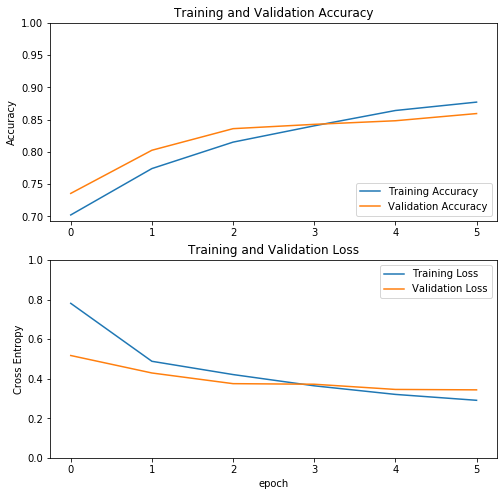

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

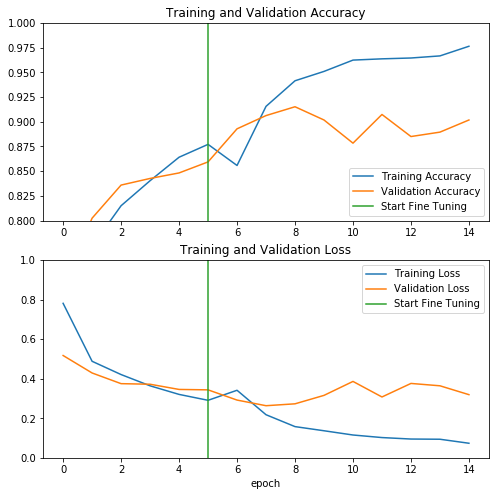

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

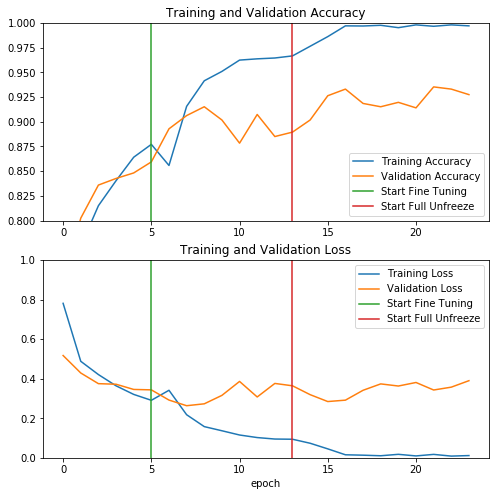

In [39]:
acc += history_unfreeze.history['accuracy']
val_acc += history_unfreeze.history['val_accuracy']

loss += history_unfreeze.history['loss']
val_loss += history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([(EPOCHS+fine_tune_epochs)-1,(EPOCHS+fine_tune_epochs)-1],
          plt.ylim(), label='Start Full Unfreeze')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([(EPOCHS+fine_tune_epochs)-1,(EPOCHS+fine_tune_epochs)-1],
          plt.ylim(), label='Start Full Unfreeze')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
np.save(output_dir / 'history.npy', history.history)

In [41]:
np.save(output_dir / 'history_fine.npy', history_fine.history)

In [42]:
np.save(output_dir / 'history_unfreeze.npy', history_unfreeze.history)

In [43]:
metrics = model.evaluate(test_ds, steps=TEST_STEPS_PER_EPOCH)

56/56 [==============================] - 15s 262ms/step - loss: 0.2785 - accuracy: 0.9475


In [44]:
metrics

[0.2785460409868392, 0.94754463]

In [45]:
np.save(output_dir / 'metrics.npy', metrics)

In [46]:
preds_test = model.predict(test_ds, steps=TEST_STEPS_PER_EPOCH)

In [47]:
preds_test

array([[-6.1640625,  5.2226562],
       [-3.4140625,  2.9375   ],
       [ 6.5      , -4.0664062],
       ...,
       [ 4.15625  , -3.5332031],
       [-5.4375   ,  3.7402344],
       [ 4.8164062, -3.2773438]], dtype=float32)

In [48]:
'''


array([[-32.25894   ,  32.056854  ],
       [  7.0108976 ,  -6.9475126 ],
       [-23.331366  ,  23.353052  ],
       ...,
       [-59.394188  ,  58.86675   ],
       [  0.42477864,  -0.4468029 ],
       [  3.9026434 ,  -3.8859158 ]], dtype=float32)

'''

'\n\n\narray([[-32.25894   ,  32.056854  ],\n       [  7.0108976 ,  -6.9475126 ],\n       [-23.331366  ,  23.353052  ],\n       ...,\n       [-59.394188  ,  58.86675   ],\n       [  0.42477864,  -0.4468029 ],\n       [  3.9026434 ,  -3.8859158 ]], dtype=float32)\n\n'

In [49]:
np.save(output_dir / 'preds_test.npy', preds_test)

In [50]:
import pandas as pd

In [51]:
test_df = pd.read_csv("./test.csv")
test_df.head()

,image,fracture
0,2.25.274592009758208995279460787419196955313.png,1
1,2.25.175552767549680817669297268272621888929.png,0
2,2.25.315818670744170950531779076713940713632.png,0
3,2.25.52597438239940829991563796927050348692.png,1
4,2.25.173379723665659969130001896828694512914.png,0


In [52]:
y_test = test_df['fracture'].values

In [53]:
y_test

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,

In [54]:
np.save(output_dir / 'y_test.npy', y_test)